# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

### Model description

- Model architecture: Xception
- Fractal module used: None 
- Number of layers tuned: 1 

### Load the ISIC Archive dataset

In [3]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [4]:
class LesionClassifier(tf.keras.Model):
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.inside_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.inside_model.layers:
            if layer.name in ['block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False            
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        outputs = self.inside_model(inputs)
        outputs = self.dense(outputs)
        
        return outputs

In [5]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
947/947 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.7361
Epoch 1: val_loss improved from inf to 0.71267, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 8193s 9s/step - loss: 0.7785 - accuracy: 0.7361 - val_loss: 0.7127 - val_accuracy: 0.7531
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7658
Epoch 2: val_loss improved from 0.71267 to 0.64753, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 7458s 8s/step - loss: 0.6761 - accuracy: 0.7658 - val_loss: 0.6475 - val_accuracy: 0.7781
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.7790
Epoch 3: val_loss improved from 0.64753 to 0.62539, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6365s 7s/step - loss: 0.6283 - accuracy: 0.7790 - val_loss: 0.6254 - val_accuracy: 0.7870
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7916
Epoch 4: val_loss improved from 0.62539 to 0.61568, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 5525s 6s/step - loss: 0.5866 - accuracy: 0.7916 - val_loss: 0.6157 - val_accuracy: 0.7901
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.8043
Epoch 5: val_loss improved from 0.61568 to 0.61481, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4879s 5s/step - loss: 0.5541 - accuracy: 0.8043 - val_loss: 0.6148 - val_accuracy: 0.7871
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8113
Epoch 6: val_loss did not improve from 0.61481
947/947 [==============================] - 4224s 4s/step - loss: 0.5287 - accuracy: 0.8113 - val_loss: 0.6191 - val_accuracy: 0.7914
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 0.4975 - accuracy: 0.8231
Epoch 7: val_loss did not improve from 0.61481
947/947 [==============================] - 4143s 4s/step - loss: 0.4975 - accuracy: 0.8231 - val_loss: 0.6193 - val_accuracy: 0.7872
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.8288
Epoch 8: val_loss improved from 0.61481 to 0.58332, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4037s 4s/step - loss: 0.4742 - accuracy: 0.8288 - val_loss: 0.5833 - val_accuracy: 0.7991
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8380
Epoch 9: val_loss did not improve from 0.58332
947/947 [==============================] - 11177s 12s/step - loss: 0.4551 - accuracy: 0.8380 - val_loss: 0.6254 - val_accuracy: 0.7949
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.8455 
Epoch 10: val_loss did not improve from 0.58332
947/947 [==============================] - 12299s 13s/step - loss: 0.4326 - accuracy: 0.8455 - val_loss: 0.6185 - val_accuracy: 0.8010
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8507
Epoch 11: val_loss did not improve from 0.58332
947/947 [==============================] - 12082s 13s/step - loss: 0.4151 - accuracy: 0.8507 - val_loss: 0.6070 - val_accuracy: 0.7999
Epoch 12/30
947/947 [=======

### Testing

In [10]:
model.load_weights(checkpoint_path)

In [11]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [12]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 263s 2s/step


In [13]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [14]:
auc_metric

{'actinic keratosis': 0.9525304095525053,
 'basal cell carcinoma': 0.9632959877846818,
 'dermatofibroma': 0.9109983281585861,
 'melanoma': 0.8845116910568,
 'nevus': 0.9423412115818113,
 'pigmented benign keratosis': 0.9515807666303993,
 'seborrheic keratosis': 0.9240514492262947,
 'solar lentigo': 0.9655588139459107,
 'squamous cell carcinoma': 0.938173185361947,
 'vascular lesion': 0.9746197288153654}

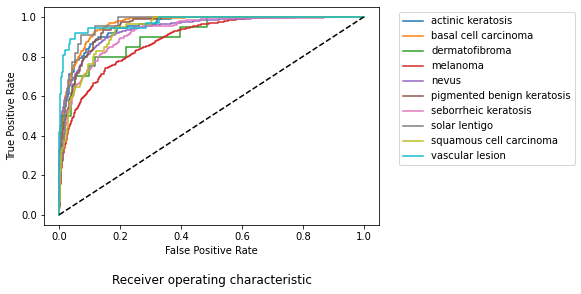

In [15]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [16]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

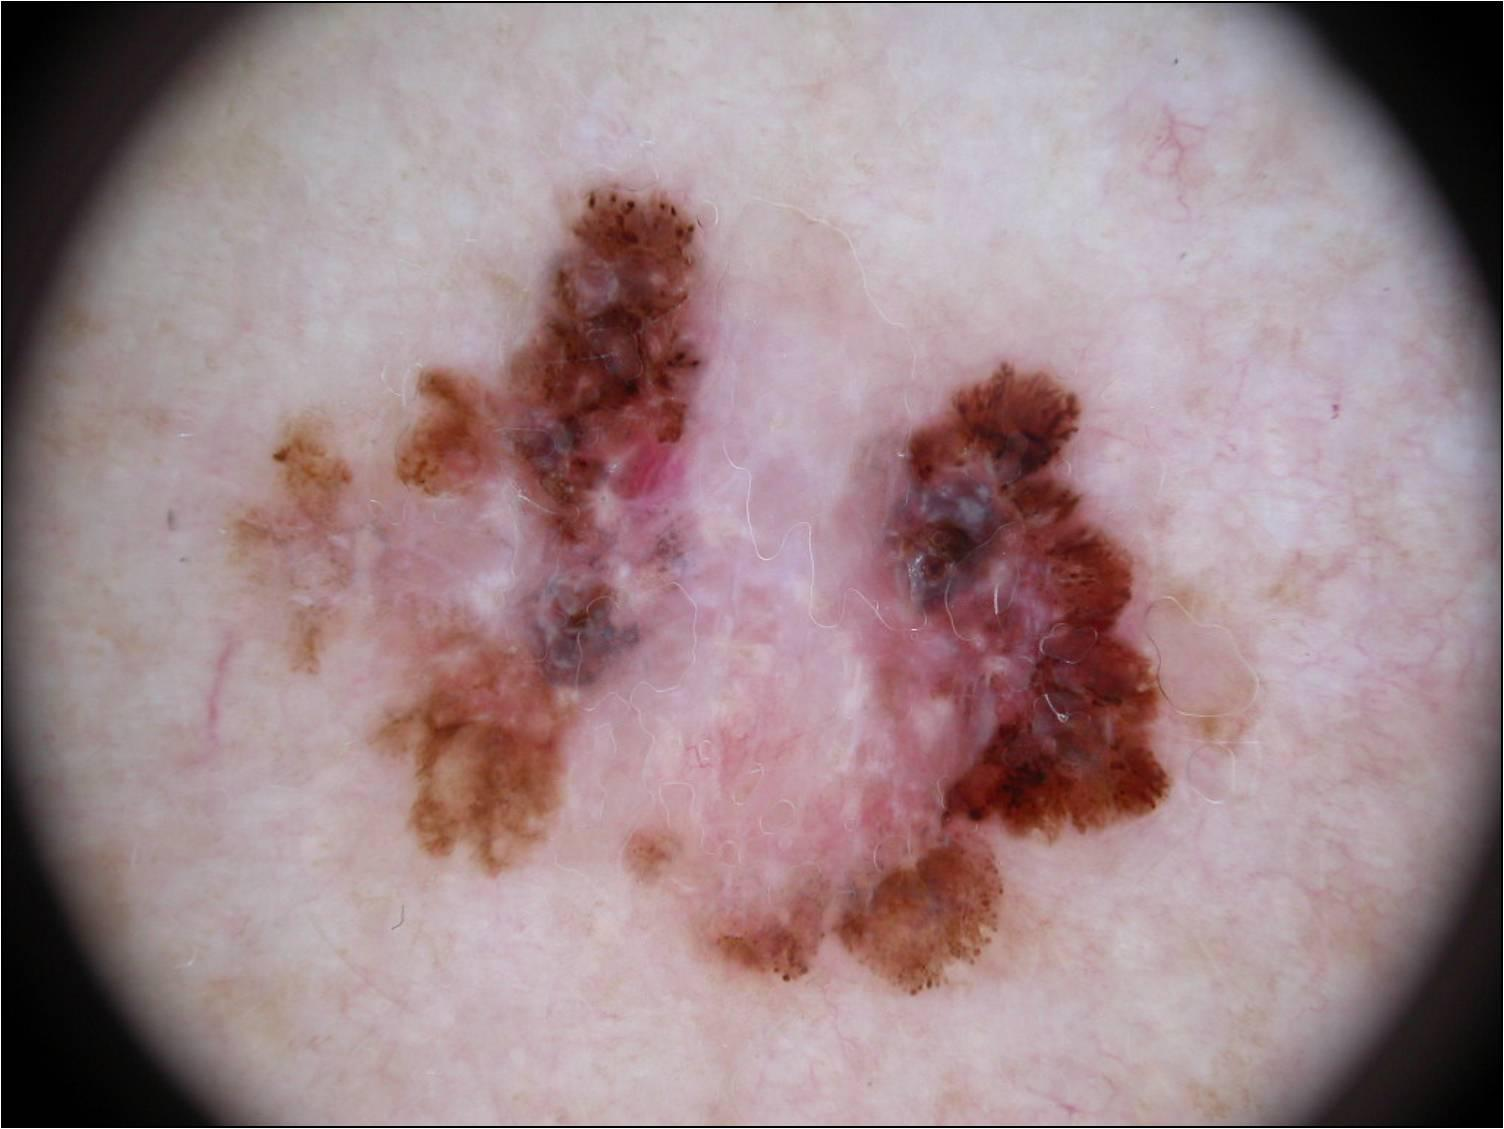

In [17]:
display(Image(melanoma_im_path, width=600))

In [18]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [19]:
heatmap = make_gradcam_heatmap(img_array, model.inside_model, 'block14_sepconv2')

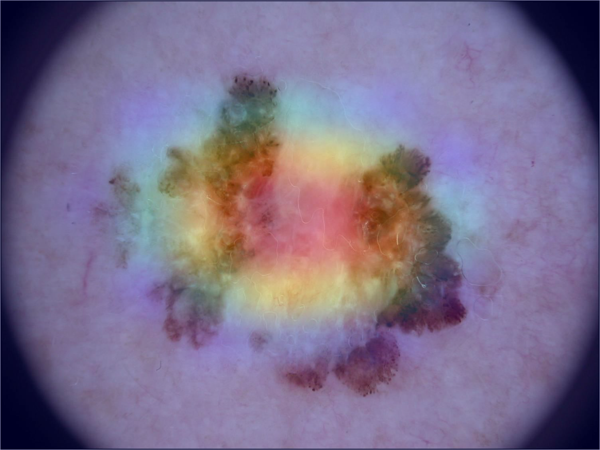

In [20]:
display_gradcam(melanoma_im_path, heatmap)